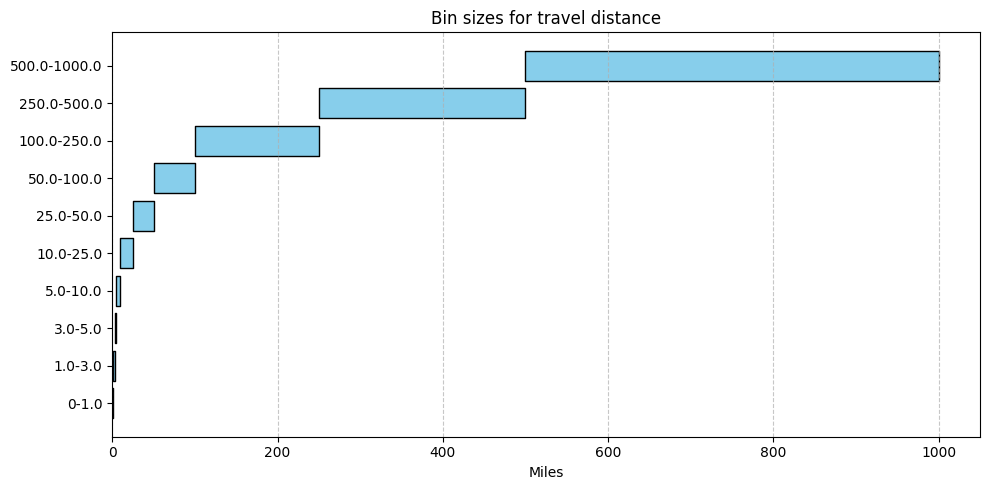

In [3]:
import matplotlib.pyplot as plt

# Bin definitions
ranges = [(0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, 10.0), (10.0, 25.0),
          (25.0, 50.0), (50.0, 100.0), (100.0, 250.0), (250.0, 500.0), (500.0, 1000.0)]

# Prepare data for broken_barh: (start, width)
bar_data = [(start, end - start) for start, end in ranges]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Draw the horizontal bars
for i, (start, width) in enumerate(bar_data):
    ax.broken_barh([(start, width)], (i - 0.4, 0.8), facecolors='skyblue', edgecolors='black')

# Y-axis labels
ax.set_yticks(range(len(ranges)))
ax.set_yticklabels([f"{start}-{end}" for start, end in ranges])

# X-axis label and title
ax.set_xlabel("Miles")
ax.set_title("Bin sizes for travel distance")

# Grid and limits
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_xlim(0, 1050)

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual file path)
df = pd.read_csv("../data/National_only.csv")

# Define bin edges (must match your trip columns)
bin_edges = np.array([0, 1.0, 3.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0])

# Extract daily trip counts by bin (using your column names)
trip_cols = [
    'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
    'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50',
    'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500',
    'Number of Trips >=500'
]
daily_counts = df[trip_cols].values
n_days, n_bins = daily_counts.shape

# Total trips per day (needed for the multinomial likelihood)
total_trips = daily_counts.sum(axis=1)

In [5]:


with pm.Model() as model:
    # Create unregistered distributions for initial values using the .dist() API:
    mu_init = pm.Normal.dist(mu=2.5, sigma=1.0)
    sigma_init = pm.HalfNormal.dist(sigma=1.0)
    
    # Random walk for mu and sigma over time.
    # The init values now come from the unregistered distributions.
    mu = pm.GaussianRandomWalk("mu", sigma=0.1, shape=n_days, init=mu_init)
    sigma = pm.GaussianRandomWalk("sigma", sigma=0.05, shape=n_days, init=sigma_init)

    # Compute the bin probabilities for each day.
    bin_probs = []
    for t in range(n_days):
        p_t = []
        for i in range(n_bins):
            lower = np.log(bin_edges[i] + 1e-6)   # avoid log(0) by adding a small epsilon
            upper = np.log(bin_edges[i+1])
            # Use the error function to compute the CDF of the log-normal.
            cdf_upper = pm.math.erf((upper - mu[t]) / (sigma[t] * np.sqrt(2)))
            cdf_lower = pm.math.erf((lower - mu[t]) / (sigma[t] * np.sqrt(2)))
            prob = 0.5 * (cdf_upper - cdf_lower)
            p_t.append(prob)
        p_t = pm.math.stack(p_t)
        p_t /= pm.math.sum(p_t)  # Ensure that the probabilities sum to 1.
        bin_probs.append(p_t)
        print(f"Step 1 {(t/n_days)*100}% complete")
    
    # Likelihood: for each day t, the observed daily bin counts are modeled with a Multinomial.
    for t in range(n_days):
        pm.Multinomial(f"obs_{t}", n=int(total_trips[t]), p=bin_probs[t], observed=daily_counts[t])
        print(f"Step 2 {(t/n_days)*100}% complete")

    # Sample from the posterior.
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

# Summarize the posterior distributions.
print(az.summary(trace))

# Optional: Plot the posterior trend for mu and sigma over time.
az.plot_trace(trace, var_names=["mu", "sigma"])
plt.show()


c:\Users\cohenl\Downloads\Big Data Project\v2\.venv\Lib\site-packages\pymc\distributions\timeseries.py:290: FutureWarning: init parameter is now called init_dist. Using init will raise an error in a future release.
  warnings.warn(
c:\Users\cohenl\Downloads\Big Data Project\v2\.venv\Lib\site-packages\pymc\distributions\timeseries.py:290: FutureWarning: init parameter is now called init_dist. Using init will raise an error in a future release.
  warnings.warn(


Step 1 0.0% complete
Step 1 0.11098779134295228% complete
Step 1 0.22197558268590456% complete
Step 1 0.3329633740288568% complete
Step 1 0.4439511653718091% complete
Step 1 0.5549389567147613% complete
Step 1 0.6659267480577136% complete
Step 1 0.776914539400666% complete
Step 1 0.8879023307436182% complete
Step 1 0.9988901220865706% complete
Step 1 1.1098779134295227% complete
Step 1 1.2208657047724751% complete
Step 1 1.3318534961154271% complete
Step 1 1.4428412874583796% complete
Step 1 1.553829078801332% complete
Step 1 1.6648168701442843% complete
Step 1 1.7758046614872365% complete
Step 1 1.8867924528301887% complete
Step 1 1.9977802441731412% complete
Step 1 2.108768035516093% complete
Step 1 2.2197558268590454% complete
Step 1 2.3307436182019976% complete
Step 1 2.4417314095449503% complete
Step 1 2.5527192008879025% complete
Step 1 2.6637069922308543% complete
Step 1 2.774694783573807% complete
Step 1 2.885682574916759% complete
Step 1 2.9966703662597114% complete
Step 1 3.1

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
df_long = df.melt(id_vars=['Date'], value_vars=cols, 
                  var_name='Bin', value_name='Trip_Count')

# Map each bin label to its representative midpoint (Distance) and bin width:
df_long['Distance']   = df_long['Bin'].map(distance_bins)
df_long['Bin_Width']  = df_long['Bin'].map(bin_widths)

# Option A: Compute normalized density (trips per mile)
df_long['Trips_per_Mile'] = df_long['Trip_Count'] / df_long['Bin_Width']

# Option B (for count modeling): Use raw counts with an offset.
# Compute the offset (log of the bin width); this allows the model
# to account for the fact that wider bins naturally have more trips.
df_long['log_Bin_Width'] = np.log(df_long['Bin_Width'])

# It is often helpful to transform Distance to reduce skew.
# We'll use a log transform (adding 1 to avoid log(0)).
df_long['Log_Distance'] = np.log1p(df_long['Distance'])

# Let's inspect the transformed data:
print(df_long.head(10))